### Topic modelling on tweets

In [115]:
#importing required libraries
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
import re
import os
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from umap import UMAP
import dataframe_image as dfi
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Running the topic modelling on the 1000 tweets as a 100 was too little.

In [82]:

# loading the data into a dataframe
df = pd.read_excel('../../data/test/1000_random_rows_24_07_2020.xlsx')
display(df)

,created_at_fuzzy,state_likely_tweeted_from,text,source,display_text_width,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,favourites_count
0,2020-07-24T22:09:10Z,Minnesota,"@harconsulting Bet trump backs out of it, when...",Twitter Web App,64,en,1,1,False,26181,28653,1,48506,68822
1,2020-07-21T00:19:06Z,Texas,@BillOReilly Why would schools being closed en...,Twitter Web App,280,en,0,0,False,216,1348,2,6905,15218
2,2020-07-24T05:14:11Z,Colorado,@EliTheAverage @TheRickWilson We don't even kn...,Twitter for Android,278,en,0,0,False,866,454,17,2027,174
3,2020-07-24T21:41:30Z,South Carolina,"If you guys vote anywhere near Joe Biden, it’l...",Twitter for iPhone,130,en,1,1,False,976,813,1,26913,25877
4,2020-07-23T16:47:25Z,West Virginia,Social Media Accuses Trump’s Federal Agents Of...,Twitter Web App,202,en,0,0,False,262,1114,10,40160,4607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2020-07-23T13:29:32Z,West Virginia,@real_defender @JoeBiden Tell another lie you ...,Twitter for Android,148,en,1,0,False,3639,4435,3,25773,24254
996,2020-07-24T05:52:51Z,New York,"I completely agree, so Trump shouldn’t take an...",Twitter for iPhone,111,en,1,0,True,2133,519,22,9410,12936
997,2020-07-24T13:06:55Z,Vermont,Rachel Maddow reads from court transcripts and...,Twitter for iPhone,274,en,1,0,False,4126,5000,510,140166,270691
998,2020-07-23T17:34:15Z,Alabama,"If this is happening now,or last night technic...",Twitter for iPhone,271,en,0,0,True,44,165,1,5139,2147


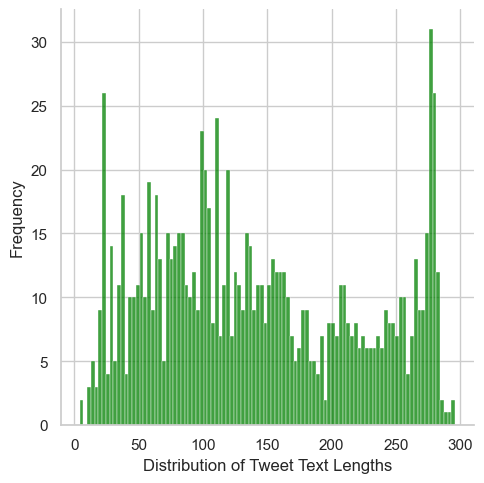

In [83]:
#adding an extra column as this is the columsn that will appear in the dataset we gave to LLM, we can of course adapt this 
# just depends which analysis we will be doing first 

df['cleaned_text'] = df['text']


# creating a new column containing the length of each headline text that is larger than 0
non_empty_lengths = df[(df['cleaned_text'].notnull()) & (df['display_text_width'] > 0)]['display_text_width']
# visualising the length distribution 

sns.set(rc={'figure.figsize':(14,11)})
sns.set(style="whitegrid")
sns.displot(non_empty_lengths, kde=False, color='green', bins=100)


plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Distribution of Tweet Text Lengths', fontsize=12)
plt.grid(True)


plt.show()

## Pre-processing the text

In [84]:
#removing line spacing and 'at' symbols
df['cleaned_text'] = df['cleaned_text'].replace('\n',' ', regex=True)
df['cleaned_text'] = df['cleaned_text'].replace('\xa0',' ', regex=True)


In [86]:

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
                      
    return re.sub(emoj, '', str(data))  # Convert data to string before removing emojis

# Apply remove_emojis function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_emojis)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)


0      @harconsulting Bet trump backs out of it, when...
1      @BillOReilly Why would schools being closed en...
2      @EliTheAverage @TheRickWilson We don't even kn...
3      If you guys vote anywhere near Joe Biden, it’l...
4      Social Media Accuses Trump’s Federal Agents Of...
                             ...                        
995    @real_defender @JoeBiden Tell another lie you ...
996    I completely agree, so Trump shouldn’t take an...
997    Rachel Maddow reads from court transcripts and...
998    If this is happening now,or last night technic...
999    WE ARE THE UNITED STATES OF AMERICA The Only w...
Name: cleaned_text, Length: 1000, dtype: object


In [89]:
import re

def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    else:
        return text

# Apply remove_numbers function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_numbers)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)



0      @harconsulting Bet trump backs out of it, when...
1      @BillOReilly Why would schools being closed en...
2      @EliTheAverage @TheRickWilson We don't even kn...
3      If you guys vote anywhere near Joe Biden, it’l...
4      Social Media Accuses Trump’s Federal Agents Of...
                             ...                        
995    @real_defender @JoeBiden Tell another lie you ...
996    I completely agree, so Trump shouldn’t take an...
997    Rachel Maddow reads from court transcripts and...
998    If this is happening now,or last night technic...
999    WE ARE THE UNITED STATES OF AMERICA The Only w...
Name: cleaned_text, Length: 1000, dtype: object


In [91]:
import string

def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    elif isinstance(text, (int, float)):
        return str(text).translate(str.maketrans('', '', string.punctuation))
    else:
        return text  # Return as is if not a string, int, or float

# Apply remove_punctuation function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_punctuation)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)


0      harconsulting Bet trump backs out of it when h...
1      BillOReilly Why would schools being closed enc...
2      EliTheAverage TheRickWilson We dont even know ...
3      If you guys vote anywhere near Joe Biden it’ll...
4      Social Media Accuses Trump’s Federal Agents Of...
                             ...                        
995    realdefender JoeBiden Tell another lie you app...
996    I completely agree so Trump shouldn’t take any...
997    Rachel Maddow reads from court transcripts and...
998    If this is happening nowor last night technica...
999    WE ARE THE UNITED STATES OF AMERICA The Only w...
Name: cleaned_text, Length: 1000, dtype: object


In [92]:
# manually replacing synonyms and words
'''
df['review_text_english'] = df['review_text_english'].str.replace(r'\b(?:bicycle|bikes)\b', 'bike', case=False, regex=True)

df['review_text_english'] = df['review_text_english'].str.replace('places', 'place', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('parkeerplaats', 'parking', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('easily', 'easy', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('authentica', 'authentic', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('genial', 'great', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('pŕ', 'pr', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('combinatie', 'combination', case=False)
'''

"\ndf['review_text_english'] = df['review_text_english'].str.replace(r'\x08(?:bicycle|bikes)\x08', 'bike', case=False, regex=True)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('places', 'place', case=False)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('parkeerplaats', 'parking', case=False)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('easily', 'easy', case=False)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('authentica', 'authentic', case=False)\ndf['review_text_english'] = df['review_text_english'].str.replace('genial', 'great', case=False)\ndf['review_text_english'] = df['review_text_english'].str.replace('pŕ', 'pr', case=False)\ndf['review_text_english'] = df['review_text_english'].str.replace('combinatie', 'combination', case=False)\n"

1. case-normalization


In [93]:
text_list = df['cleaned_text'].tolist()

# case normalization function
def case_normalization(text):
    return text.lower()

# apply case normalization to each element of the text list
normalized_text_list = [case_normalization(word) for word in text_list]

print(normalized_text_list)


['harconsulting bet trump backs out of it when he remembers nyc hates his guts', 'billoreilly why would schools being closed encourage me to vote for biden hes in the throws of cognitive decline my innerconspiracy theorist voice is saying the virus was released intentionally to unseat president trump the timing of it after russian hoax after impeachment is uncanny', 'elitheaverage therickwilson we dont even know who these soldiers are for christ sake  they may not even be federal authorities they might be trumps buddy betsy devioss brother erik princes private militia  blocktrumpers impeachtrumpagain istandwithfauci antimaskerproblems  trumpsgestapo', 'if you guys vote anywhere near joe biden it’ll be a socialist country and we’re fucked and by we i mean you and i specifically', 'social media accuses trump’s federal agents of committing a war crime after unverified video shows medical equipment covered in what appears to be pepper spray httpstcobnxalvnbj via politribune', 'sure let the

## Visualisation of word distribution

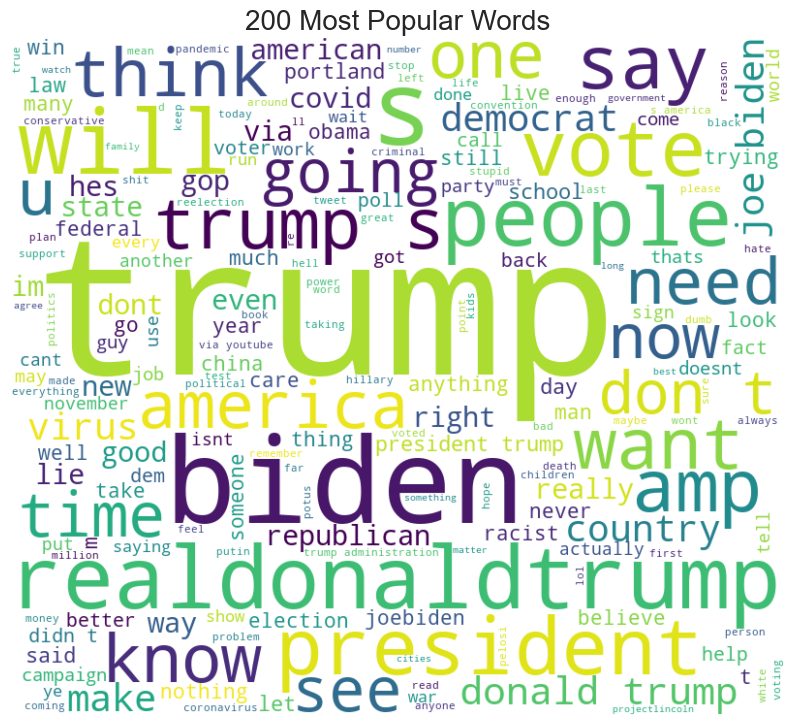

In [94]:
# words visualisation with a wordcloud
concatenated_text = ' '.join(normalized_text_list)
# generating
wordcloud = WordCloud(width=800, height=700, max_words=200, background_color='white').generate(concatenated_text)

# plotting the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('200 Most Popular Words', size= 20)
plt.show()

## Further pre-processing for topic modelling

2. tokenization

In [95]:
def tokenization(text):
    return text.split()
    
tokenized_text_list = [tokenization(word) for word in normalized_text_list]

print(tokenized_text_list)

[['harconsulting', 'bet', 'trump', 'backs', 'out', 'of', 'it', 'when', 'he', 'remembers', 'nyc', 'hates', 'his', 'guts'], ['billoreilly', 'why', 'would', 'schools', 'being', 'closed', 'encourage', 'me', 'to', 'vote', 'for', 'biden', 'hes', 'in', 'the', 'throws', 'of', 'cognitive', 'decline', 'my', 'innerconspiracy', 'theorist', 'voice', 'is', 'saying', 'the', 'virus', 'was', 'released', 'intentionally', 'to', 'unseat', 'president', 'trump', 'the', 'timing', 'of', 'it', 'after', 'russian', 'hoax', 'after', 'impeachment', 'is', 'uncanny'], ['elitheaverage', 'therickwilson', 'we', 'dont', 'even', 'know', 'who', 'these', 'soldiers', 'are', 'for', 'christ', 'sake', 'they', 'may', 'not', 'even', 'be', 'federal', 'authorities', 'they', 'might', 'be', 'trumps', 'buddy', 'betsy', 'devioss', 'brother', 'erik', 'princes', 'private', 'militia', 'blocktrumpers', 'impeachtrumpagain', 'istandwithfauci', 'antimaskerproblems', 'trumpsgestapo'], ['if', 'you', 'guys', 'vote', 'anywhere', 'near', 'joe', '

3. stopwords removal 

In [96]:

custom_stopwords = ['€']

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english')).union(set(custom_stopwords or []))  # adding the custom stopwords and english
    return [token for token in tokens if token not in stop_words]

tokens = [remove_stopwords(word) for word in tokenized_text_list]
print(tokens)

[['harconsulting', 'bet', 'trump', 'backs', 'remembers', 'nyc', 'hates', 'guts'], ['billoreilly', 'would', 'schools', 'closed', 'encourage', 'vote', 'biden', 'hes', 'throws', 'cognitive', 'decline', 'innerconspiracy', 'theorist', 'voice', 'saying', 'virus', 'released', 'intentionally', 'unseat', 'president', 'trump', 'timing', 'russian', 'hoax', 'impeachment', 'uncanny'], ['elitheaverage', 'therickwilson', 'dont', 'even', 'know', 'soldiers', 'christ', 'sake', 'may', 'even', 'federal', 'authorities', 'might', 'trumps', 'buddy', 'betsy', 'devioss', 'brother', 'erik', 'princes', 'private', 'militia', 'blocktrumpers', 'impeachtrumpagain', 'istandwithfauci', 'antimaskerproblems', 'trumpsgestapo'], ['guys', 'vote', 'anywhere', 'near', 'joe', 'biden', 'it’ll', 'socialist', 'country', 'we’re', 'fucked', 'mean', 'specifically'], ['social', 'media', 'accuses', 'trump’s', 'federal', 'agents', 'committing', 'war', 'crime', 'unverified', 'video', 'shows', 'medical', 'equipment', 'covered', 'appears

In [97]:
# transforming into a string to create a model
tokens = [str(token) for token in tokens]
print(tokens)
tokens = [string.strip("'") for string in tokens if string.strip("[]").strip("'")]

["['harconsulting', 'bet', 'trump', 'backs', 'remembers', 'nyc', 'hates', 'guts']", "['billoreilly', 'would', 'schools', 'closed', 'encourage', 'vote', 'biden', 'hes', 'throws', 'cognitive', 'decline', 'innerconspiracy', 'theorist', 'voice', 'saying', 'virus', 'released', 'intentionally', 'unseat', 'president', 'trump', 'timing', 'russian', 'hoax', 'impeachment', 'uncanny']", "['elitheaverage', 'therickwilson', 'dont', 'even', 'know', 'soldiers', 'christ', 'sake', 'may', 'even', 'federal', 'authorities', 'might', 'trumps', 'buddy', 'betsy', 'devioss', 'brother', 'erik', 'princes', 'private', 'militia', 'blocktrumpers', 'impeachtrumpagain', 'istandwithfauci', 'antimaskerproblems', 'trumpsgestapo']", "['guys', 'vote', 'anywhere', 'near', 'joe', 'biden', 'it’ll', 'socialist', 'country', 'we’re', 'fucked', 'mean', 'specifically']", "['social', 'media', 'accuses', 'trump’s', 'federal', 'agents', 'committing', 'war', 'crime', 'unverified', 'video', 'shows', 'medical', 'equipment', 'covered',

5. stemming and lemmatization

In [98]:

# initialising stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# stemming
stemmed_words = [stemmer.stem(token) for token in tokens]

# lemmatization
lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]


print("Stemmed Tokens:", stemmed_words)
print("Lemmatized Tokens:", lemmatized_words)
tokens = lemmatized_words

Stemmed Tokens: ["['harconsulting', 'bet', 'trump', 'backs', 'remembers', 'nyc', 'hates', 'guts']", "['billoreilly', 'would', 'schools', 'closed', 'encourage', 'vote', 'biden', 'hes', 'throws', 'cognitive', 'decline', 'innerconspiracy', 'theorist', 'voice', 'saying', 'virus', 'released', 'intentionally', 'unseat', 'president', 'trump', 'timing', 'russian', 'hoax', 'impeachment', 'uncanny']", "['elitheaverage', 'therickwilson', 'dont', 'even', 'know', 'soldiers', 'christ', 'sake', 'may', 'even', 'federal', 'authorities', 'might', 'trumps', 'buddy', 'betsy', 'devioss', 'brother', 'erik', 'princes', 'private', 'militia', 'blocktrumpers', 'impeachtrumpagain', 'istandwithfauci', 'antimaskerproblems', 'trumpsgestapo']", "['guys', 'vote', 'anywhere', 'near', 'joe', 'biden', 'it’ll', 'socialist', 'country', 'we’re', 'fucked', 'mean', 'specifically']", "['social', 'media', 'accuses', 'trump’s', 'federal', 'agents', 'committing', 'war', 'crime', 'unverified', 'video', 'shows', 'medical', 'equipm

# Analysis

1. Bag of words 

In [99]:
def bag_of_words(tokens):
    return Counter(tokens)

bag_of_words(tokens)

Counter({"['harconsulting', 'bet', 'trump', 'backs', 'remembers', 'nyc', 'hates', 'guts']": 1,
         "['billoreilly', 'would', 'schools', 'closed', 'encourage', 'vote', 'biden', 'hes', 'throws', 'cognitive', 'decline', 'innerconspiracy', 'theorist', 'voice', 'saying', 'virus', 'released', 'intentionally', 'unseat', 'president', 'trump', 'timing', 'russian', 'hoax', 'impeachment', 'uncanny']": 1,
         "['elitheaverage', 'therickwilson', 'dont', 'even', 'know', 'soldiers', 'christ', 'sake', 'may', 'even', 'federal', 'authorities', 'might', 'trumps', 'buddy', 'betsy', 'devioss', 'brother', 'erik', 'princes', 'private', 'militia', 'blocktrumpers', 'impeachtrumpagain', 'istandwithfauci', 'antimaskerproblems', 'trumpsgestapo']": 1,
         "['guys', 'vote', 'anywhere', 'near', 'joe', 'biden', 'it’ll', 'socialist', 'country', 'we’re', 'fucked', 'mean', 'specifically']": 1,
         "['social', 'media', 'accuses', 'trump’s', 'federal', 'agents', 'committing', 'war', 'crime', 'unverifie

# Modelling

In [113]:
# preparing embeddings
sentence_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
embeddings = sentence_model.encode(tokens, show_progress_bar=False)

# training BERTopic
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', nr_topics=10) # min_topic_size
review_topics, _ = model.fit_transform(tokens)

# running the visualization with the original embeddings
model.visualize_documents(tokens, embeddings=embeddings)

# reducing dimensionality of embeddings
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)



2024-03-24 11:03:21,455 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 32/32 [00:01<00:00, 17.96it/s]
2024-03-24 11:03:24,371 - BERTopic - Embedding - Completed ✓
2024-03-24 11:03:24,371 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-24 11:03:28,046 - BERTopic - Dimensionality - Completed ✓
2024-03-24 11:03:28,047 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-24 11:03:28,096 - BERTopic - Cluster - Completed ✓
2024-03-24 11:03:28,097 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-24 11:03:28,141 - BERTopic - Representation - Completed ✓
2024-03-24 11:03:28,141 - BERTopic - Topic reduction - Reducing number of topics
2024-03-24 11:03:28,142 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


In [114]:
#appending the dataset with a coolumn "topic"
topics, _ = model.fit_transform(df['cleaned_text'])
# Assign topic labels to each tweet in the dataset
df['topic_label'] = topics

# Save the DataFrame with the new column
df.to_csv('dataset_with_topic_labels.csv', index=False)

2024-03-24 11:05:49,078 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s]
2024-03-24 11:05:55,846 - BERTopic - Embedding - Completed ✓
2024-03-24 11:05:55,847 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-24 11:05:59,023 - BERTopic - Dimensionality - Completed ✓
2024-03-24 11:05:59,024 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-24 11:05:59,073 - BERTopic - Cluster - Completed ✓
2024-03-24 11:05:59,074 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-24 11:05:59,139 - BERTopic - Representation - Completed ✓
2024-03-24 11:05:59,140 - BERTopic - Topic reduction - Reducing number of topics
2024-03-24 11:05:59,141 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3


In [101]:


# get topic vectors
topic_vectors = model.transform(tokens)

# compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(topic_vectors)

# Display the similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)

Batches: 100%|██████████| 32/32 [00:02<00:00, 13.89it/s]
2024-03-24 10:57:06,329 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-03-24 10:57:06,337 - BERTopic - Dimensionality - Completed ✓
2024-03-24 10:57:06,337 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-03-24 10:57:06,399 - BERTopic - Cluster - Completed ✓


Cosine Similarity Matrix:
[[1.         0.80495679]
 [0.80495679 1.        ]]


In [102]:
model.visualize_documents(tokens, reduced_embeddings=reduced_embeddings)

### Topic Extraction and Representation

In [103]:

os.environ["TOKENIZERS_PARALLELISM"] = "false"

frequency = model.get_topic_info()
print("Number of topics: {}".format( len(frequency)))
display(frequency)
dfi.export(frequency, 'dataframe_topics.png')

Number of topics: 7


,Topic,Count,Name,Representation,Representative_Docs
0,-1,693,-1_trump_biden_president_like,"[trump, biden, president, like, people, realdo...","[['biden', 'slightly', 'votes', 'trump', 'amp'..."
1,0,32,0_trump_trumps_america_voteharwell,"[trump, trumps, america, voteharwell, httpstco...","[['trumps', 'america', 'httpstcoqqumrneou'], [..."
2,1,37,1_trump_don_thehill_knows,"[trump, don, thehill, knows, projectlincoln, h...","[['rumorsofmeaning', 'trump', 'fails', 'realiz..."
3,2,21,2_realdonaldtrump_teamtrump_trump_bot,"[realdonaldtrump, teamtrump, trump, bot, bye, ...","[['teamtrump', 'realdonaldtrump', 'httpstcohun..."
4,3,30,3_realdonaldtrump_trump_president_fauci,"[realdonaldtrump, trump, president, fauci, pan...","[['realdonaldtrump', 'cares', 'ratings', 'tied..."
5,4,133,4_biden_joe_joebiden_amp,"[biden, joe, joebiden, amp, vote, trump, presi...","[['i’m', 'attending', 'joe', 'biden', 'preside..."
6,5,54,5_trump_like_people_think,"[trump, like, people, think, words, cant, know...","[['kthomasellis', 'timhannan', 'trump', 'pushe..."


-1 refers to all outliers and should typically be ignored. The most frequent topic that was generated, topic 0:

In [104]:
model.get_topic(0)

[('trump', 0.1720571981138692),
 ('trumps', 0.1685942460157903),
 ('america', 0.1646477323453232),
 ('voteharwell', 0.08989313772272625),
 ('httpstcoqhtswkivi', 0.08989313772272625),
 ('frankbranches', 0.08470064341279762),
 ('real', 0.07215475196051929),
 ('via', 0.05050477997897062),
 ('httpstcojyhzryarh', 0.049386930563527644),
 ('httpstcovrfxgctfq', 0.049386930563527644)]

In [105]:
model.get_document_info(tokens)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,"['harconsulting', 'bet', 'trump', 'backs', 're...",1,1_trump_don_thehill_knows,"[trump, don, thehill, knows, projectlincoln, h...","[['rumorsofmeaning', 'trump', 'fails', 'realiz...",trump - don - thehill - knows - projectlincoln...,1.000000,False
1,"['billoreilly', 'would', 'schools', 'closed', ...",4,4_biden_joe_joebiden_amp,"[biden, joe, joebiden, amp, vote, trump, presi...","[['i’m', 'attending', 'joe', 'biden', 'preside...",biden - joe - joebiden - amp - vote - trump - ...,0.685544,False
2,"['elitheaverage', 'therickwilson', 'dont', 'ev...",-1,-1_trump_biden_president_like,"[trump, biden, president, like, people, realdo...","[['biden', 'slightly', 'votes', 'trump', 'amp'...",trump - biden - president - like - people - re...,0.000000,False
3,"['guys', 'vote', 'anywhere', 'near', 'joe', 'b...",4,4_biden_joe_joebiden_amp,"[biden, joe, joebiden, amp, vote, trump, presi...","[['i’m', 'attending', 'joe', 'biden', 'preside...",biden - joe - joebiden - amp - vote - trump - ...,0.792832,False
4,"['social', 'media', 'accuses', 'trump’s', 'fed...",-1,-1_trump_biden_president_like,"[trump, biden, president, like, people, realdo...","[['biden', 'slightly', 'votes', 'trump', 'amp'...",trump - biden - president - like - people - re...,0.000000,False
...,...,...,...,...,...,...,...,...
995,"['realdefender', 'joebiden', 'tell', 'another'...",-1,-1_trump_biden_president_like,"[trump, biden, president, like, people, realdo...","[['biden', 'slightly', 'votes', 'trump', 'amp'...",trump - biden - president - like - people - re...,0.000000,False
996,"['completely', 'agree', 'trump', 'shouldn’t', ...",-1,-1_trump_biden_president_like,"[trump, biden, president, like, people, realdo...","[['biden', 'slightly', 'votes', 'trump', 'amp'...",trump - biden - president - like - people - re...,0.000000,False
997,"['rachel', 'maddow', 'reads', 'court', 'transc...",-1,-1_trump_biden_president_like,"[trump, biden, president, like, people, realdo...","[['biden', 'slightly', 'votes', 'trump', 'amp'...",trump - biden - president - like - people - re...,0.000000,False
998,"['happening', 'nowor', 'last', 'night', 'techn...",4,4_biden_joe_joebiden_amp,"[biden, joe, joebiden, amp, vote, trump, presi...","[['i’m', 'attending', 'joe', 'biden', 'preside...",biden - joe - joebiden - amp - vote - trump - ...,0.818021,False


Top terms and c-TF-IDF scores

In [106]:
a_topic = frequency.iloc[1]["Topic"] # selecting the 1st topic
model.get_topic(a_topic) # showing the words and their c-TF-IDF scores

[('trump', 0.1720571981138692),
 ('trumps', 0.1685942460157903),
 ('america', 0.1646477323453232),
 ('voteharwell', 0.08989313772272625),
 ('httpstcoqhtswkivi', 0.08989313772272625),
 ('frankbranches', 0.08470064341279762),
 ('real', 0.07215475196051929),
 ('via', 0.05050477997897062),
 ('httpstcojyhzryarh', 0.049386930563527644),
 ('httpstcovrfxgctfq', 0.049386930563527644)]

### Topic visualisation


In [107]:

model.visualize_barchart(top_n_topics=17, n_words= 10, width = 300, height = 350)

In [108]:
model.visualize_topics()

In [109]:
# Calculate the percentage representation of topics

your_docs = tokens
topic_counts = Counter(review_topics)
total_documents = len(your_docs)
topic_percentages = {topic: count / total_documents * 100 for topic, count in topic_counts.items()}
topic_percentages = {topic: round(count / total_documents * 100, 2) for topic, count in topic_counts.items()}

# Create a DataFrame from the topic percentages
df_topic_percentages = pd.DataFrame(list(topic_percentages.items()), columns=['Topic', 'Percentage of documents in a topic'])
df_topic_percentages = df_topic_percentages.sort_values(by='Topic', ascending=True)
df_topic_percentages['Percentage of documents in a topic'] = df_topic_percentages['Percentage of documents in a topic'].astype(str) + '%'

# Display the DataFrame
display(df_topic_percentages)

dfi.export(df_topic_percentages, 'dataframe_topics%.png')

,Topic,Percentage of documents in a topic
2,-1,69.3%
5,0,3.2%
0,1,3.7%
6,2,2.1%
3,3,3.0%
1,4,13.3%
4,5,5.4%


In [110]:
model.visualize_hierarchy(top_n_topics=30)

In [111]:
similar_topics, similarity = model.find_topics("politics", top_n = 3)
most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

Most Similar Topic Info: 
[('trump', 0.1456568872921644), ('don', 0.05710345695164244), ('thehill', 0.04810316797367953), ('knows', 0.04710031585042112), ('projectlincoln', 0.04539285750640004), ('help', 0.04121046794146585), ('unless', 0.03995250565454501), ('much', 0.038774561055153686), ('im', 0.03661375219255073), ('country', 0.03583563518197069)]
Similarity Score: 0.23517464101314545


In [112]:
#saving the model
model.save("bert_best_model_tweets")

# loading the serialised model
my_best_model = BERTopic.load("bert_best_model_tweets")
my_best_model

2024-03-24 10:57:18,151 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
